In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors
from IPython.display import display, clear_output

import package_DBR
import package_LAB

from datetime import datetime
import tclab
import time

import os


from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode
from importlib import reload
package_LAB = reload(package_LAB)
from package_LAB import PID_RT, LeadLag_RT,IMCTuning,Scenario_Box,Show_scenario

 
 # Process parameters 


In [2]:
#SOPDT  for PV
Kp = 0.3870268878656955
T1p = 134.48964045587033
T2p = 0.18834872361511124
thetap = 4.428370012941102

#SOPDT  for DV change it later!!
Kd =  0.281747169668043
T1d = 67.89840042973015
T2d = 69.30791379520285
thetad = 7.00000023376638


In [3]:
gamma = 0.4 
Kc,Ti,Td = IMCTuning(Kp,T1p,T2p,thetap,gamma,'SOPDT')
print(Kc,Ti,Td)

5.976566556991808 134.67798917948545 0.1880853157494045


In [4]:
TSim = 2000
Ts = 1
N = int(TSim/Ts) + 1


# CLOSED LOOP with PID and FF


In [5]:
#working point 
MV0= 50
DV0 = 50
PV0 = 75

MVPath = {0: 1, 1230: 0, TSim: 1}

## SCENAREOS

In [6]:
help(Scenario_Box)

Help on function Scenario_Box in module package_LAB:

Scenario_Box()
    This function will help us make the choice of the scenareo please uncheck a simulation before checking another



In [7]:
Scenario_Box()

Checkbox(value=False, description='OPLnoFF')

Checkbox(value=False, description='OPLFF')

Checkbox(value=False, description='CLPFF')

Checkbox(value=False, description='CLPnoFF')

In [8]:
help(Show_scenario)

Help on function Show_scenario in module package_LAB:

Show_scenario()
    This function is MANDATORY to apply the scenario choice.. it also make us sure of the choice made



In [19]:
scenario = Show_scenario()

You have chosen an closed loop with  feedforward


In [20]:
print(scenario)

if scenario=="OPLnoFF":
    ManPath = {0: True,TSim: True} 
    MVManPath = {0: MV0, TSim: MV0} 
    SPPath = {0: PV0, 1000: PV0-10, TSim: PV0-10} 
    DVPath = {0: DV0-20, 1500: DV0, TSim: DV0}
    ManFF = False
    ActivateFF= False
    print(1)
    
   
    
elif scenario =='OPLFF':
    ManPath = {0: True,TSim: True}
    MVManPath = {0: MV0, TSim: MV0} 
    SPPath = {0: PV0, 1200: PV0-10, TSim: PV0-10} 
    DVPath = {0: DV0-20, 1700: DV0, TSim: DV0}
    ManFF = True
    ActivateFF= True
    print(2)

elif scenario=='CLPFF':
    ManPath = {0: False, 100: False, TSim: False}
    MVManPath = {0: 100, TSim: MV0}
    SPPath = {0: PV0, 1000: PV0-10, TSim: PV0-10} 
    DVPath = {0: DV0-20, 1500: DV0, TSim: DV0}
    ManFF = True
    ActivateFF= True
    print(3)
   
    
else:
    ManPath = {0: False, 1000 :False, TSim: False}
    MVManPath = {0: MV0, TSim: MV0} 
    SPPath = {0: PV0, 1000: PV0-10, TSim: PV0-10} 
    DVPath = {0: DV0-20, 1500: DV0, TSim: DV0}
    ManFF = False
    ActivateFF = False
    print(4)
  




CLPFF
3


In [21]:
t=[]
SP=[]
PV=[]
Man=[]
MVMan=[]
MVFF=[]
MV=[]
DV=[]
MVP=[]
MVI=[]
MVD=[]
E=[]

alpha = 0.5
MVMin = 0
MVMax = 100

MVFFDelay=[]
MVFFLL1=[]

MVDelayp=[]
PV1p=[]
PV2p=[]

MVDelayd=[]
PV1d=[]
PV2d=[]

In [22]:
def EXPERIMENT():

    global t,SP,MV,Man,ManFF,MVMan,MVFF,MVP,MVI,MVD,DV,PV,E,MVFFDelay,MVFFLL1,MVDelayp,PV1p,PV2p,MVDelayd,PV1d,PV2d

    for i in range(0,N):
        t.append(i*Ts)

        PV.append(lab.T1)
        SelectPath_RT(SPPath,t,SP)
        SelectPath_RT(DVPath,t,DV)
        Delay_RT(DV-DV0*np.ones_like(DV),np.max([thetad-thetap,0]),Ts,MVFFDelay)
        LeadLag_RT(MVFFDelay,-Kd/Kp,T1p,T1d,Ts,MVFFLL1)
        if ActivateFF :
            LeadLag_RT(MVFFLL1,1,T2p,T2d,Ts,MVFF)
        else :
            LeadLag_RT(MVFFLL1,0,T2p,T2d,Ts,MVFF)

        SelectPath_RT(ManPath,t,Man)
        SelectPath_RT(MVManPath,t,MVMan)

        PID_RT(SP,PV,Man,MVMan,MVFF,2,Ti,Td,alpha,Ts,MVMin,MVMax,MV,MVP,MVI,MVD,E,ManFF,PV0,'EBD_EBD')

        lab.Q1(MV[-1])
        lab.Q2(DV[-1])
        #MV.append(MVValue)
        #DV.append(DVValue) 
        
        i = i + 1
        time.sleep(Ts)
        
        l1.set_data(t,MV)
        l2.set_data(t,PV)
        l3.set_data(t,DV)

        clear_output(wait=True)

        # Remove if increasing x-axis length is not desired
        ax1.set_xlim(0, t[-1]+1)
        ax2.set_xlim(0, t[-1]+1)
        ax3.set_xlim(0, t[-1]+1)

        if i > 1:
            ax1.set_ylim(myRound(np.min(MV),5)-5, myRound(np.max(MV),5)+5)
            ax2.set_ylim(myRound(np.min(PV),5)-5, myRound(np.max(PV),5)+5)
            ax3.set_ylim(myRound(np.min(DV),5)-5, myRound(np.max(DV),5)+5)        

        display(fig)


    lab.close()

    # Save data into a file
    now = datetime.now()
    date_time = now.strftime("%Y-%m-%d-%Hh%M")
    t = np.array(t)
    MV = np.array(MV)
    PV = np.array(PV)
    DV = np.array(DV)
    my_data = np.vstack((t.T,MV.T,PV.T,DV.T))
    my_data = my_data.T
    nameFile = 'Data/Open_loop_experiment_on_' + scenario + '_' + date_time + '.txt'
    if not os.path.exists('Data'):
        os.makedirs('Data')
    np.savetxt(nameFile,my_data,delimiter=',',header='t,MV,PV,DV',comments='')

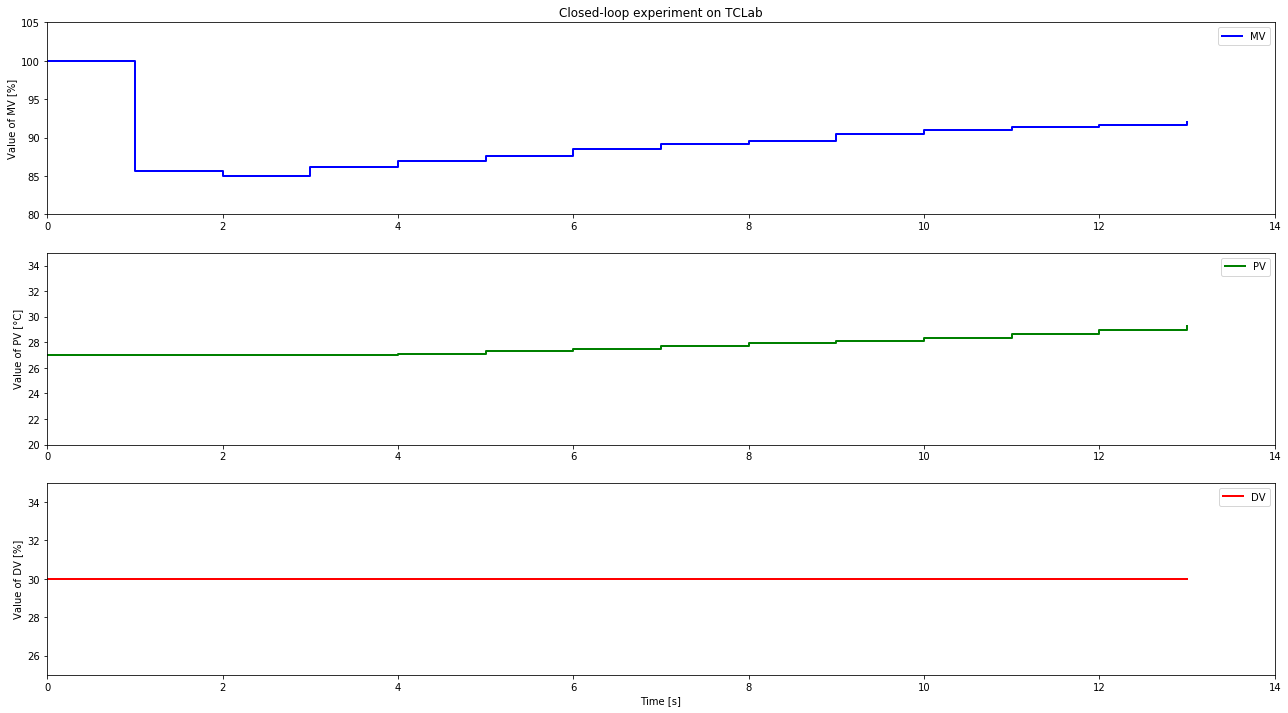

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
fig.set_figheight(12)
fig.set_figwidth(22)

l1, = ax1.step([0,1],[0,100],'b-',linewidth=2,label='MV',where='post')
ax1.set_ylabel('Value of MV [%]')
ax1.set_title('Closed-loop experiment on TCLab')
ax1.legend(loc='best')

l2, = ax2.step([0,1],[0,100],'g-',linewidth=2,label='PV',where='post')
ax2.set_ylabel('Value of PV [°C]')
ax2.legend(loc='best')

l3, = ax3.step([0,1],[0,100],'r-',linewidth=2,label='DV',where='post')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Value of DV [%]')
ax3.legend(loc='best')
lab = tclab.TCLab()

t = []
i = 0
MV = []
DV = []
PV = []

EXPERIMENT()

In [18]:
nameFile = "Open_loop_experiment_on_CLPnoFF_2022-05-18-13h20"
fig.savefig("Plots/"+nameFile + '.png',transparent=True)
fig.savefig("Plots/"+nameFile + '.pdf',transparent=True)  
